In [78]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit import pulse, transpile, schedule
from qiskit.pulse.library import Gaussian
from qiskit.providers.fake_provider import FakeValencia
import numpy as np
from qiskit.circuit import Gate, Parameter
import matplotlib.pyplot as plt
from qiskit.pulse.library import Drag

In [79]:
from qiskit.visualization import plot_histogram


In [80]:
import qiskit

# Understading Pulse

In qiskit we usually use gate-level programming to manipulate our quantum circuit, which makes it possible for the user to create quantum algorithms, implement experiments and many other features. However in order to truly manipulate the qubits in the superconducting hardware we need to implement pulses, just like the actual quantum system does firing microwave pulses at the qubits. Using Pulse you have more control of the qubit, being able to control many parameters of the qubit, such as, phase, amplitude, frequency and many others. However, differently from gate-level operations in which time does not matter, nor the especific qubit, since the "dynamics of the quantum system are abstractd as a sequence of unitary gate operations
and projective measurements applied to a set of qubits"[1] in the pulse-level there are time-dependent dynamics and they operate on physical qubits, meaning that the calibrations made on a certain qubit, will not be the same on a different qubit. Not only that, but another important difference is that they are not as precise as when you use gate operations. Operation on the pulse level can be very advantageous for quantum error-correction and variational quantum algorithms.

Qiskit Pulse is composed of pulses, channels and instructions:


*   **Pulses:** A pulse is a time series of complex-valued amplitudes with a maximum unit norm $[d_0, d_1, ..., d_{n-1}]$, where wach $d_j$ is called a sample. The pulse sample describe the envelopes of the produced signal. You can also use already made parametric pulse shapes, such as a Gaussian Pulse, which has three parameters, duration, amplitude and standard deviation.
*   **Channels:** The Channels model the hardware components of the qubit, receiving and sending sinals, modeling the quantum operationson the quantum processor. They are unique for each qubit, since it depends on the physical properties of the qubits, so the same using the same channels for different qubits will not generate the same result, differently from the Gate operations which are universal. There are two channels and three subchannels: the PulseChannel, which manipulate the quantum systems and have three subtypes Drive, Measure and Control. The control applys pulses to the qubits, with specific amplitudes, frequencies and phases, they are responsible for the quantum gates, for example. The Measure Channel measures the state of the qubit after performing the manipulations. The Control Channel is more general then the drive one, applying control operations on the qubits. Also there is the Acquire Channel, which after measuring the qubit it stores the values obtained. The table shown in the cell below has a summary of the channel and its utilities.
*    **Instructions:** Instructions are specific operations applied on the quantum processor that are passed through the channels. These instructions are also described in the table below.

Another important aspect is the Pulse Schedule which is the passing of a sequence of instructions to determined channels, here you define the characteristics and the **timing** of the instructions, since the pulse schedule happens in a chronological order.

**Scheduling** is like the transpile function, but for the pulse. Transpiling the circuit reorganizes the gates selected by the user for the topology of the backend that is being used and to the native gates of that backend. The Scheduler complies the circuit program to the pulse program, putting the gates in the 'pulse language' and to the specificities of the system being used. Scheduling can be used in the gates, like X, H, Cnot, etc. where they will transform these gates in pulses - this can be seen in the code- or can give the user more low-level control and let it create custom gate, specifying order, time and building pulse sequences as you wish -also done in the code below.



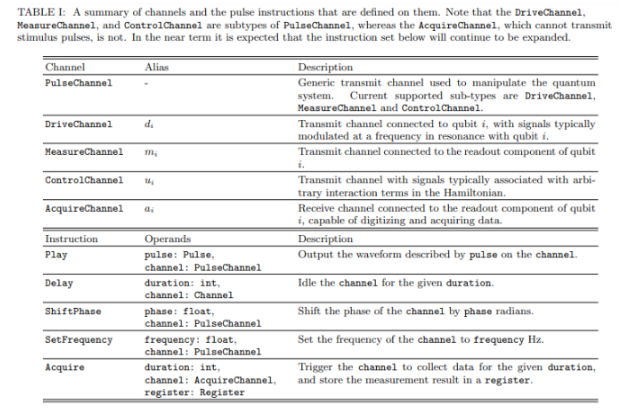

### References:

  The table is taken from the article below:

[1] Alexander, T., Kanazawa, N., Egger, D. J., Capelluto, L., Wood, C. J., Javadi-Abhari, A., & McKay, D. C. (2020). Qiskit pulse: programming quantum computers through the cloud with pulses. Quantum Science and Technology, 5(4), 044006.


---



Liang, Z., Cheng, J., & Wang, H. (2023, November, 1). Enhance Variational Quantum Algorithms with Qiskit Pulse and Qiskit Dynamics. Medium. https://medium.com/qiskit/enhance-variational-quantum-algorithms-with-qiskit-pulse-and-qiskit-dynamics-768249daf8dd


---



IBM Quantum. 2023. IBM Quantum Documentation - Qiskit Pulse. Retrieved from https://docs.quantum.ibm.com/build/pulse

---
Qiskit. 2023. Calibrating Qubits: Pulse. Qiskit Textbook. Retrieved from https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html

Qiskit Aer 0.13 has dropped support for PulseSimulator following deprecation warnings started in Qiskit Aer 0.12. Use Qiskit Dynamics to run pulse-level simulation. https://qiskit.org/ecosystem/dynamics/

I am using an older version of qiskit in order to utilize the same methods as most tutorials out there;

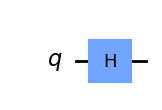

In [124]:


circ = QuantumCircuit(1)
circ.h(0)


circ.draw('mpl')

# Below is a Hadamard gate, using Gate operations

In [7]:

simulator = Aer.get_backend('aer_simulator_statevector')
backend = FakeValencia()


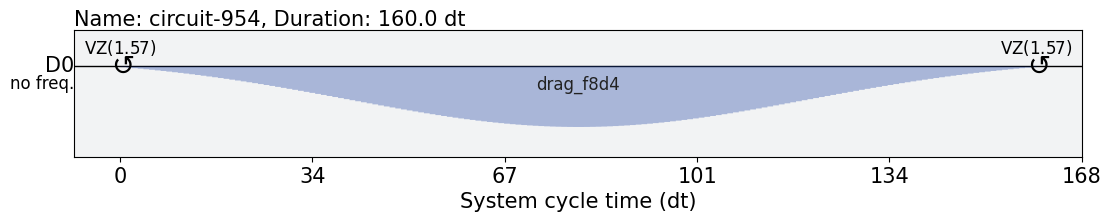

In [126]:
transpiled_circ = transpile(circ, backend) ### Here we transpile the circuit into the architecture of the backend, with
# its basic gates, as shown in the next code
schedule_circ = schedule(transpiled_circ, backend)
# Here we know these basic gates have a correspondent pulse, which is already calibrated;
schedule_circ.draw()

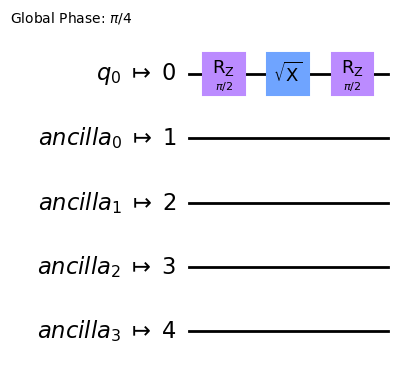

In [127]:
transpiled_circ.draw('mpl')

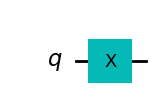

In [128]:
qc_xgate = QuantumCircuit(1)
qc_xgate.x(0)
qc_xgate.draw('mpl')

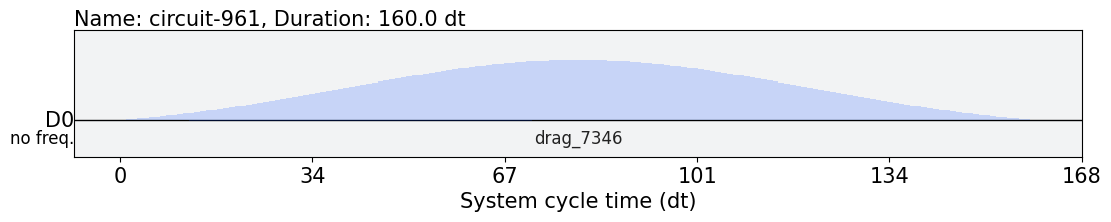

In [129]:
transpiled_x_circ = transpile(qc_xgate, backend)
schedule_x_circ = schedule(transpiled_x_circ, backend)

schedule_x_circ.draw()
# we can see it only uses the drive channels

In [130]:
schedule_x_circ.filter(channels = [pulse.DriveChannel(0)])

Schedule((0, Play(Drag(duration=160, amp=(0.19290084722113582+0j), sigma=40, beta=-0.25388969010654494, name='drag_7346'), DriveChannel(0), name='drag_7346')), name="circuit-961")

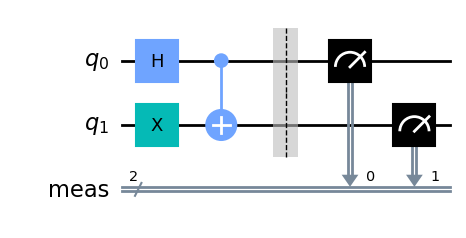

In [133]:
c = QuantumCircuit(2)
c.h(0)
c.x(1)
c.cx(0,1)
c.measure_all()
c.draw('mpl')

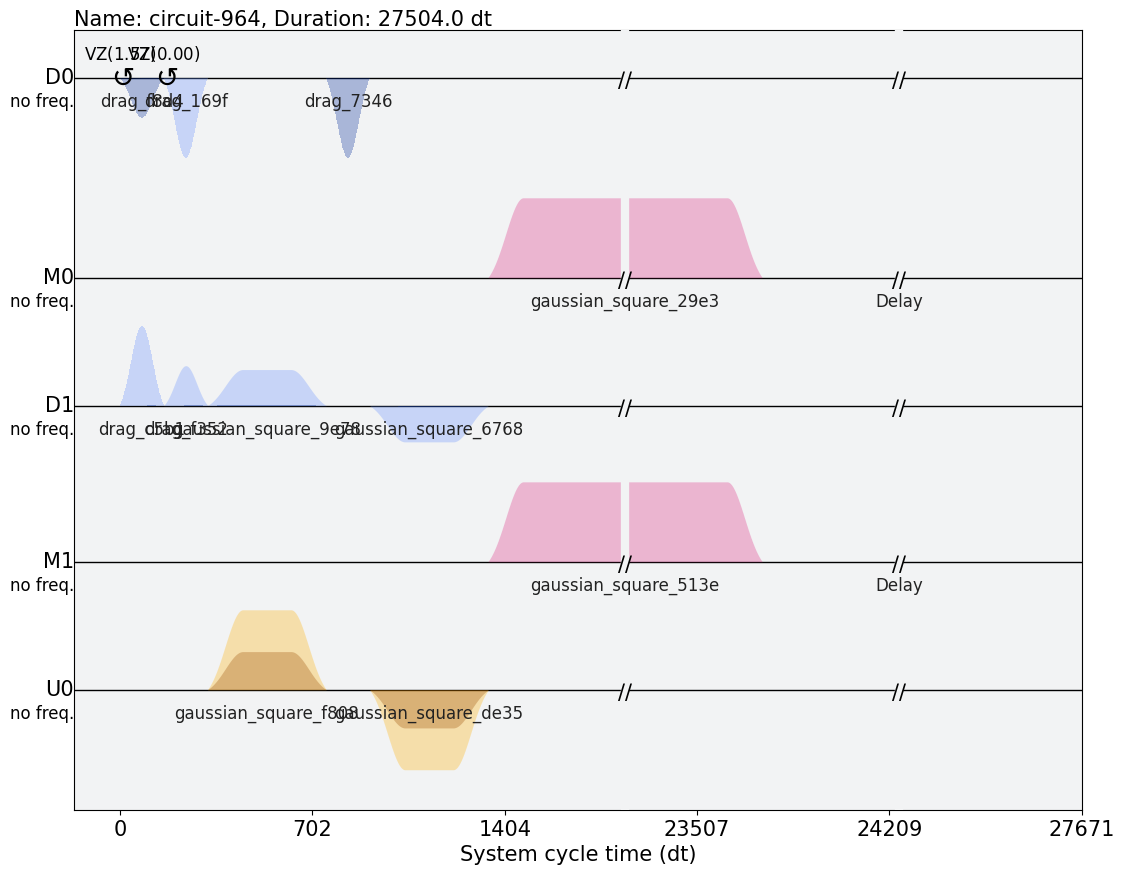

In [134]:
transp_c = transpile(c, backend)
schedule_c = schedule(transp_c, backend)

schedule_c.draw()

# so here we see the drive, measure and control channel all being used

**Optimizing the X-gate**

We will now optimize the X-gate, calibrating it to give out the best result possible. In simulations with perfect backends the probability of finding the qubit in the state |1> after applying the X gate is of 1.0, but in noisy backends we know that this does not happen, as shown below. However using the pulse we can calibrate the gate to perform the operation more precisely, as can be seen below.


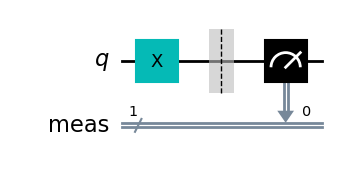

In [81]:
qc = QuantumCircuit(1)
qc.x(0)
qc.measure_all()
qc.draw('mpl')

In [82]:
# Job simulated by the perfect simulator
job_simul = simulator.run(qc, shots = 2000)
res_sim = job_simul.result().get_counts()
# Job simulate by the Fake Backend
job_r = backend.run(transpile(qc, backend), shots = 2000)
res_r = job_r.result().get_counts()



In [24]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
### since the plot_histogram function from qiskit is not printing it quite right I asked Chat-Gpt to build this function
def custom_plot_histogram(data, legend=None):
    """
    Custom implementation of plot_histogram function.
    
    Args:
        data (list[dict]): List of dictionaries containing counts for different outcomes.
        legend (list[str], optional): List of strings specifying the legend for each data entry.

    Returns:
        None
    """
    fig, ax = plt.subplots()
    
    # Width of each bar
    bar_width = 0.35
    # Set index for each bar group
    index = np.arange(len(data[0]))
    
    # Plot each dataset
    for i, counts in enumerate(data):
        # Calculate position for bars
        offset = i * bar_width
        outcomes = list(counts.keys())
        values = list(counts.values())
        ax.bar(index + offset, values, bar_width, label=legend[i] if legend else None)
    
    ax.legend()
    ax.set_xlabel('Outcome')
    ax.set_ylabel('Counts')
    ax.set_title('Histogram')
    
    # Adjust x-axis ticks
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(outcomes)
    plt.grid()
    plt.show()

We can see that while the simulator gives all results in |1> the fake backend does not.

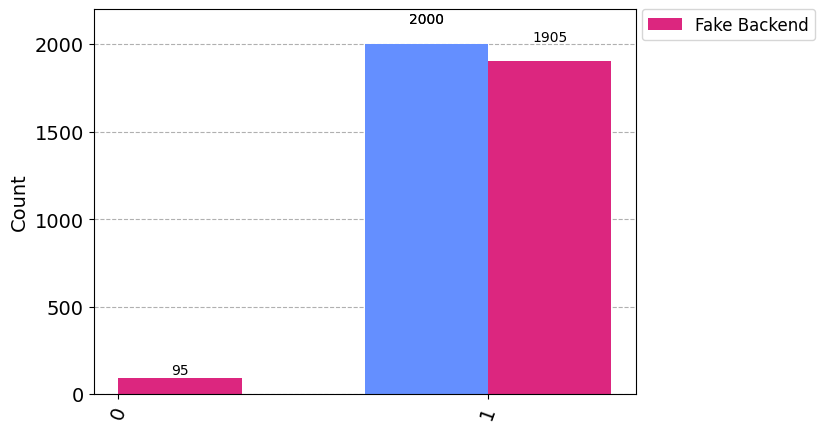

In [83]:
plot_histogram([res_sim,res_r ], legend = ['Aer Simulator', 'Fake Backend'])

Here we will create a **custom gate** using Qiskit Pulse and calibrate it to get better results


C:\Users\pedro\anaconda3\envs\qiskit-39\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:163: UserWarning: Style JSON file 'iqp.json' not found in any of these locations: C:\Users\pedro\anaconda3\envs\qiskit-39\lib\site-packages\qiskit\visualization\circuit\styles\iqp.json, iqp.json. Will use default style.
  self._style, def_font_ratio = load_style(style)


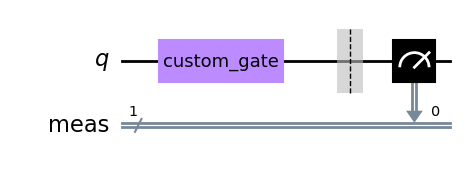

In [84]:


amp = Parameter('amp') # Parameter for Amplitude

ci = QuantumCircuit(1)
custom_gate = Gate('custom_gate', 1, []) # created custom gate, in the first qubit, but have not put the parameters yet

ci.append(custom_gate,[0])# putting the custom gate in the qubit 0 in the Quantum Circuit
ci.measure_all()

ci.draw('mpl', style='iqp')

In [8]:
i = 0.18 # Arbitrary value for the Amplitude

from qiskit.pulse.library import Drag # the pulse library has predefined pulse shapes, such as Drag, Gaussian, etc.

with pulse.build(backend, name = 'custom_x') as my_sched:
    pulse.play(Drag(duration = 160, sigma = 40, amp = amp, beta =-0.25388969010654494 ), pulse.DriveChannel(0))

my_sched.assign_parameters({amp:i})



ScheduleBlock(Play(Drag(duration=160, amp=(0.18+0j), sigma=40, beta=-0.25388969010654494), DriveChannel(0)), name="custom_x", transform=AlignLeft())

In [9]:
ci.add_calibration(custom_gate, [0], my_sched)

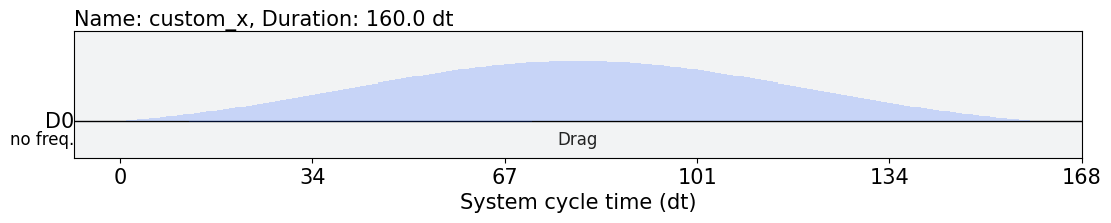

In [10]:
my_sched.draw()

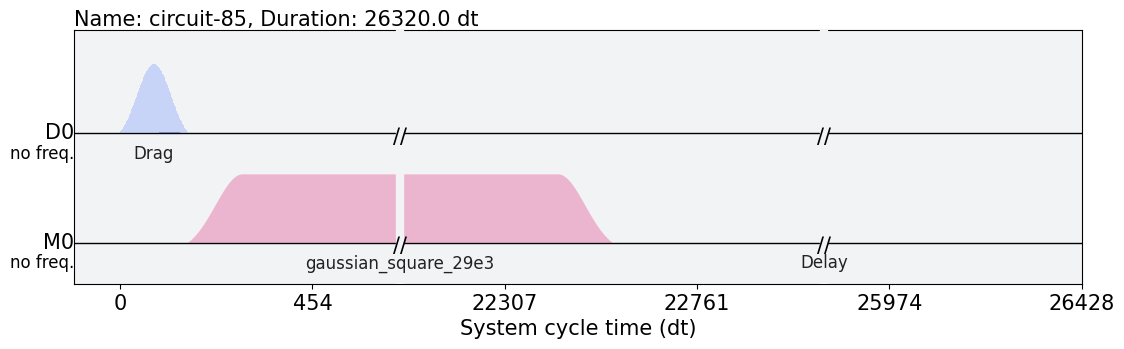

In [11]:
ci_trans = transpile(ci, backend)

schedule_ci = schedule(ci_trans, backend)

schedule_ci.draw()

In [73]:
schedule_x_circ.filter(channels = [pulse.MeasureChannel(0)])

Schedule((160, Play(GaussianSquare(duration=22400, amp=(0.075+0j), sigma=64, width=22144, name='gaussian_square_29e3'), MeasureChannel(0), name='gaussian_square_29e3')), (22560, Delay(3760, MeasureChannel(0))), name="circuit-624")

In [12]:
job = backend.run(schedule_ci,shots = 2000)

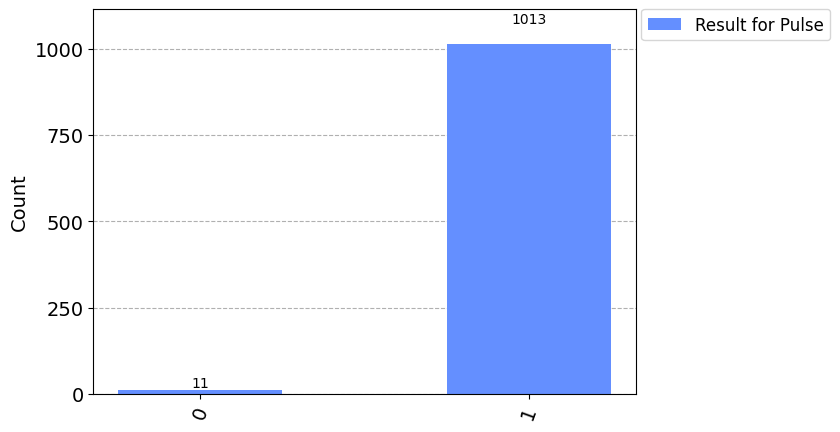

In [15]:
plot_histogram(job.result().get_counts(), legend = ['Result for Pulse'])

## Simulation - Optimal Value


The result above is not great, almost the same as the gate operation - a little better- but we can find the best amplitude to perform this operation by using the scipy function which minimizes the function according to a certain parameter, in this case we find the parameter for the amplitude which returns the least amount of qubits in the zero state.

In [85]:
def amp_op(parameter):
  # now lets optimize the parameter for the X gate:
  amp = Parameter('amp')
  circ = QuantumCircuit(1)
  c_gate = Gate('custom_gate', 1, [])
  circ.append(c_gate, [0])
  circ.measure_all()

  with pulse.build(backend, name = 'custom') as my_sched:
    pulse.play(Drag(duration = 160, sigma = 40, amp = amp, beta =-0.25388969010654494 ), pulse.DriveChannel(0))

  my_sched.assign_parameters({amp:parameter})
  circ.add_calibration(c_gate, [0], my_sched)
  circ_tras = transpile(circ, backend)
  sc_c = schedule(circ_tras, backend)
  num_shots = 1024
  job= backend.run(sc_c,shotes = num_shots)
  counts = job.result().get_counts()

  if '0' in counts:
    return(counts['0']/num_shots)
  else: return 0
  # we want to minimize the amount of zeros, since we are trying to build the optimal X gate

In [86]:
from scipy.optimize import minimize_scalar
# here we are using scipy.optimize which finds the minimum value of a given function

In [87]:
res = minimize_scalar(amp_op, bounds= (0.1, 0.21), method = 'bounded')
# in the determined boundaries we will find the value for amp that produces the least amounts of zeros # the probability of zeros
amp_optimal = res.x
print(res.x)
# the value below is the optimal value

C:\Users\pedro\anaconda3\envs\qiskit-39\lib\site-packages\qiskit_aer\pulse\controllers\pulse_controller.py:144: UserWarning: Warning: qubit_lo_freq was not specified in PulseQobj and there is no default, so it is being automatically determined from the drift Hamiltonian.
  warn('Warning: qubit_lo_freq was not specified in PulseQobj and there is no default, '


0.16953436127947377


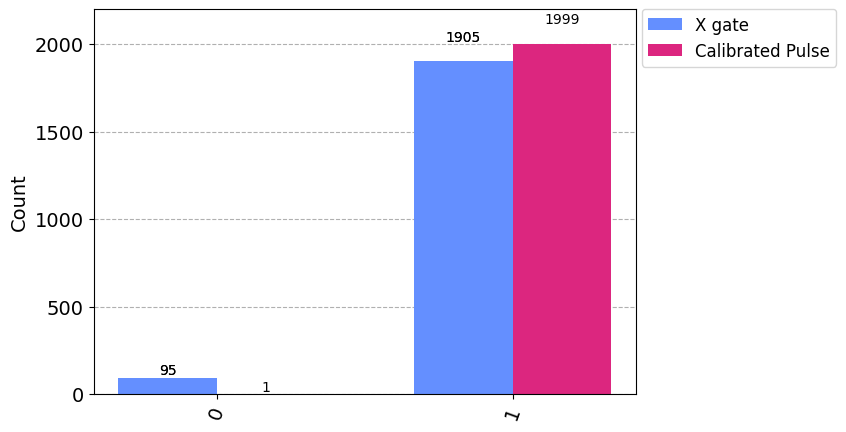

In [88]:
i = amp_optimal

from qiskit.pulse.library import Drag # the pulse library has predefined pulse shapes, such as Drag, Gaussian, etc.

with pulse.build(backend, name = 'custom_x') as my_sched:
    pulse.play(Drag(duration = 160, sigma = 40, amp = amp, beta =-0.25388969010654494 ), pulse.DriveChannel(0))

my_sched.assign_parameters({amp:i})


ci.add_calibration(custom_gate, [0], my_sched)

ci_trans = transpile(ci, backend)

schedule_ci = schedule(ci_trans, backend)

job = backend.run(schedule_ci, shots = 2000)
pl = job.result().get_counts()
plot_histogram([res_r, pl], legend = ['X gate','Calibrated Pulse'])

As it can be clearly seen the fake backend using a calibrated pulse does much better then the one that used the gate X operation.

### Using Qiskit Pulse in Real Quantum Computer
Now we will find the optimal value for the X gate using qiskit pulse for a real quantum computer. In this case ibm_kyoto backend.


**OBS.:** It is important to understand that the process of finding the optimal value will be different from the one used before, but it will also work. This will be done, because the scipy.optimize function that finds the minimum scalar cannot be used with the real backend, scince the algorithm will try to run the quantum circuits many times, without using the sampler -which actually cannot be used without Qiskit Aer 0.13.0 so it will not be done now- or putting the schedules in a list - as will be done here- so we will manually run a list of circuits with varying amplitudes to determine which will be best. First we will attempt with the same fake backend used before, just to show it works and we will proceed to testing it with a real backend.

## Simulation

In [28]:
q_try = QuantumCircuit(1)
q_try.x(0)
q_try.measure_all()
transpiled_x_circ = transpile(q_try, backend)
schedule_x_circ = schedule(transpiled_x_circ, backend)
schedule_x_circ.filter(channels = [pulse.DriveChannel(0)])

Schedule((0, Play(Drag(duration=160, amp=(0.19290084722113582+0j), sigma=40, beta=-0.25388969010654494, name='drag_7346'), DriveChannel(0), name='drag_7346')), name="circuit-624")

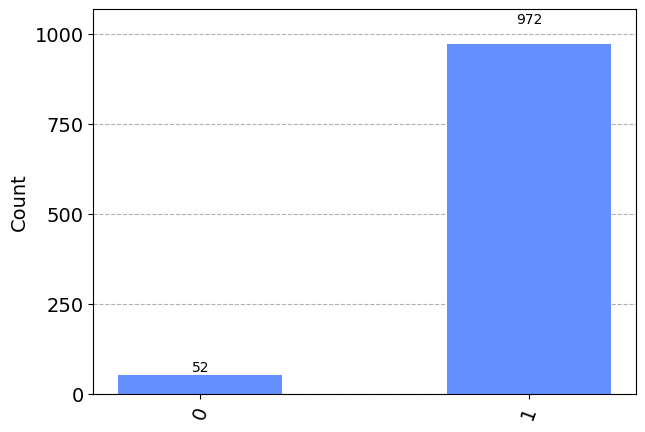

In [29]:
job = backend.run(transpiled_x_circ, shots = 2000)
from qiskit.tools.visualization import plot_histogram
sim2 = job.result().get_counts()
plot_histogram(job.result().get_counts())

In [30]:


amp = Parameter('amp') # Parameter for Amplitude

circ_real = QuantumCircuit(1)
c_gate = Gate('custom_gate', 1, []) # created custom gate, in the first qubit, but have not put the parameters yet

circ_real.append(c_gate,[0])# putting the custom gate in the qubit 0 in the Quantum Circuit
circ_real.measure_all()

amplitudes = np.linspace(0.15, 0.20, 53)
schedules = []
for i in amplitudes:
    with pulse.build(backend, name = 'custom') as my_sched:
        pulse.play(Drag(duration = 160, sigma = 40,amp = amp, beta = -0.25388969010654494), pulse.DriveChannel(0))
    sched = my_sched.assign_parameters({amp:i})
    schedules.append(sched)

In [31]:
all_circuits = [circ_real] * len(amplitudes)
circs_transpiled = []
schedules_circuits = []
for i in range(len(amplitudes)):
    all_circuits[i].add_calibration(c_gate, [0], schedules[i])
    transp = transpile(all_circuits[i], backend)
    circs_transpiled.append(transp)
    sch = schedule(transp, backend)
    schedules_circuits.append(sch)
    

In [32]:
num_shots = 2000
job= backend.run(schedules_circuits,shots = num_shots)
counts = job.result().get_counts()

C:\Users\pedro\anaconda3\envs\qiskit-39\lib\site-packages\qiskit_aer\pulse\controllers\pulse_controller.py:144: UserWarning: Warning: qubit_lo_freq was not specified in PulseQobj and there is no default, so it is being automatically determined from the drift Hamiltonian.
  warn('Warning: qubit_lo_freq was not specified in PulseQobj and there is no default, '


In [34]:
def adjust_data(data):
    for d in data:
        if '0' not in d:
            d['0'] = 0
        if '1' not in d:
            d['1'] = 0
    return data
counts_ = adjust_data(counts)

In [35]:
prob_0 = [i['0']/sum(i.values()) for i in counts]

In [36]:
indx = prob_0.index(min(prob_0))
amp_optimal = amplitudes[indx]

In [37]:
amp_optimal # which is the same as the one found with the other method

0.16634615384615384

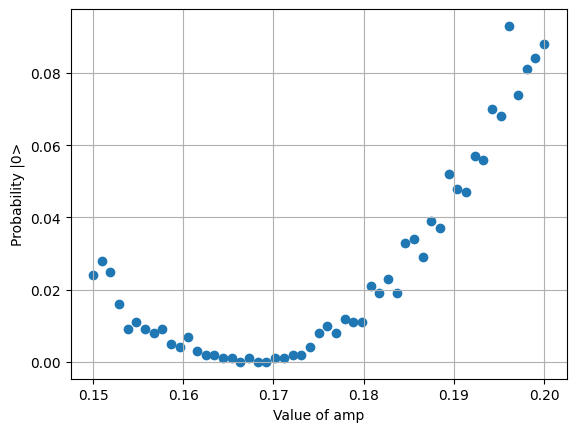

In [44]:
plt.ylabel('Probability |0>')
plt.xlabel('Value of amp')
plt.grid()

plt.scatter(amplitudes, prob_0)
plt.show()

In [72]:
len(amplitudes)

53

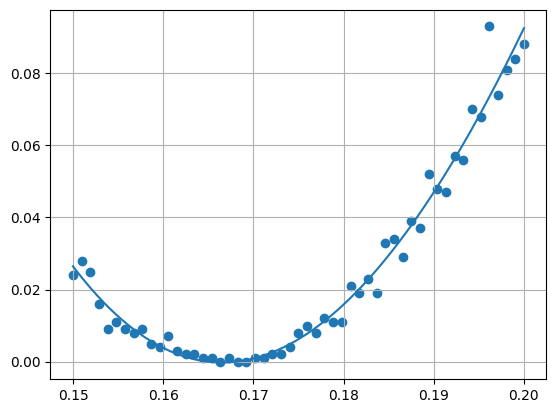

In [48]:
mymodel = np.poly1d(np.polyfit(amplitudes, prob_0, 3))

myline = np.linspace(amplitudes[0], amplitudes[-1], 300)

plt.scatter(amplitudes, prob_0)
plt.grid()
plt.plot(myline, mymodel(myline))
plt.show()

The graph above is quite interesting, because it shows that the probabilities tend to zero when they approach amplitude values close to 0.168-0.172 and then once again go back to getting bigger probabilities.

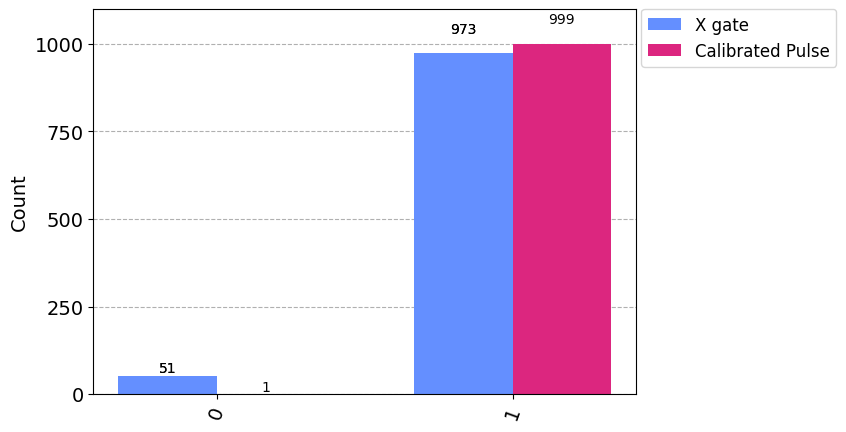

In [189]:

plot_histogram([sim2, counts[indx]], legend = ['X gate', 'Calibrated Pulse'])


## Experiment

Now that we have tested it and saw that my method also works let's try it with a **real backend** *ibm kyoto*.

In [51]:


amp = Parameter('amp') # Parameter for Amplitude

circ = QuantumCircuit(1)
gate = Gate('custom_gate', 1, []) # created custom gate, in the first qubit, but have not put the parameters yet

circ.append(gate,[0])# putting the custom gate in the qubit 0 in the Quantum Circuit
circ.measure_all()
amplitudes = np.linspace(0.15, 0.20, 23)


In [52]:
qiskit.IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub = 'ibm-q', group = 'open', project = 'main')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_brisbane') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_kyoto') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_osaka') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [53]:
backend_real = provider.get_backend('ibm_kyoto')

In [29]:
q_xgate = QuantumCircuit(1)
q_xgate.x(0)
q_xgate.measure_all()
transpiled = transpile(q_xgate, backend_real)
schedule_x_ = schedule(transpiled, backend_real)
schedule_x_.filter(channels = [pulse.DriveChannel(0)])

Schedule((0, Play(Drag(duration=120, amp=(0.1992407706675433+0j), sigma=30, beta=0.09118033565908838, name='Xp_d0'), DriveChannel(0), name='Xp_d0')), name="circuit-743")

In [69]:
duration = 120
sigma= 30
beta = 0.09118033565908838

In [53]:
all_sched = []
for i in amplitudes:
    with pulse.build(backend, name = 'custom') as my_sched:
        pulse.play(Drag(duration = duration, sigma = sigma,amp = amp, beta = beta), pulse.DriveChannel(0))
    sched_parametrized = my_sched.assign_parameters({amp:i})
    all_sched.append(sched_parametrized)

In [54]:
all_circs = [circ] * len(amps)
circs_transp = []
schedule_circ = []
for i in range(len(amps)):
    all_circs[i].add_calibration(gate, [0], all_sched[i])
    transp = transpile(all_circuits[i], backend_real)
    circs_transp.append(transp)
    sche = schedule(transp, backend_real)
    schedule_circ.append(sche)
    

In [56]:
len(schedule_circ)

23

In [49]:
num_shots = 2000
job = execute(transpiled, backend = backend_real, shots = num_shots)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

cq1ztnthbttg008qz52g
Job Status: job has successfully run


In [73]:
counts_Xgate = job.result().get_counts()

The following histogram is represents a circuit with a X gate and measurement.

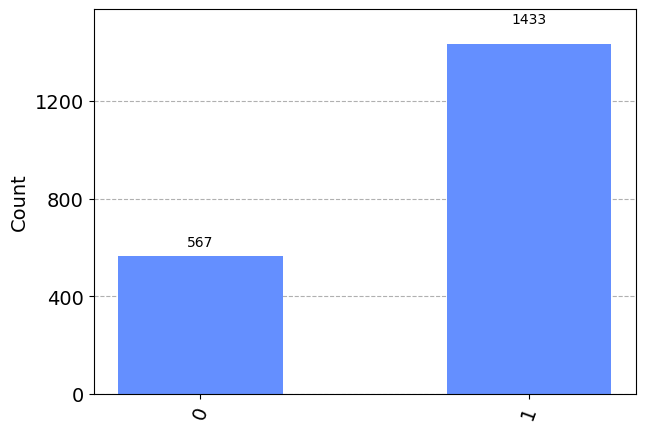

In [50]:
plot_histogram(job.result().get_counts())

In [57]:
num_shots = 2000
job_real = execute(schedule_circ, backend = backend_real, shots = num_shots)
print(job_real.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job_real)

C:\Users\pedro\anaconda3\envs\qiskit-39\lib\site-packages\qiskit\compiler\assembler.py:458: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


cq28bpyd7we0008nff10
Job Status: job has successfully run


In [59]:
counts_real = job_real.result().get_counts()

In [196]:
prob_0_1 = [i['0']/sum(i.values()) for i in counts_real]
index = prob_0.index(min(prob_0))

In [197]:
amps[index]

0.1488135593220339

The following histogram and the graph after that show that in this try to calibrate the circuit it did not do well. The Pulse performed worse when compared to the X-gate circuit. In the graph relating the probabilities to the amplitudes we see a randomness (that is why I use a plot instead of scatter), with values varying from good to bad withou and appearent pattern. 

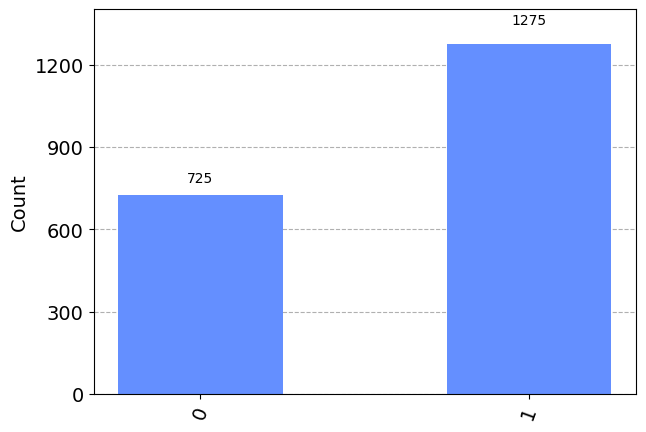

In [198]:
plot_histogram(counts_real[index])

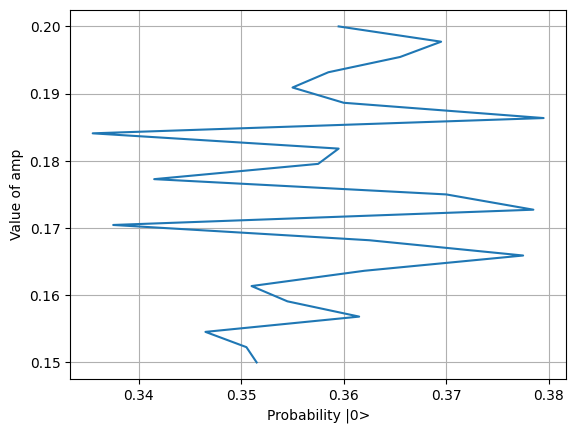

In [68]:

plt.plot(prob_0, amps)
plt.xlabel('Probability |0>')
plt.ylabel('Value of amp')
plt.grid()


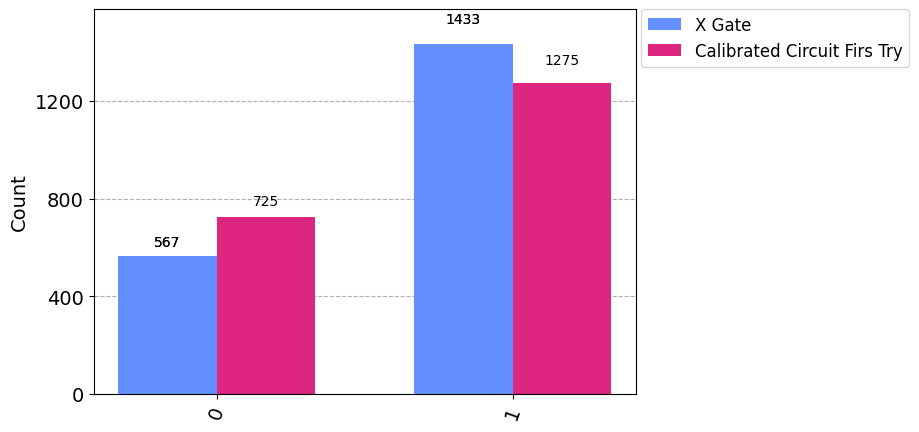

In [199]:
plot_histogram([counts_Xgate, counts_real[index]], legend = ['X Gate', 'Calibrated Circuit Firs Try'])

From this try it appears that running it on a calibrated circuit made it worse. We could not find the optimal value for amplitude to make it better then the X gate.

So now we will attempt it with more points to try to get a better value for the calibrated Pulse. Not only that, but we will also put the value given for the amplitude when we schedulle the circuit to try to see if this is the best value. 

In [61]:
amps = np.linspace(0.14, 0.205, 60)
np.append(amps, 0.19290084722113582)
np.sort(amps)

array([0.14      , 0.14110169, 0.14220339, 0.14330508, 0.14440678,
       0.14550847, 0.14661017, 0.14771186, 0.14881356, 0.14991525,
       0.15101695, 0.15211864, 0.15322034, 0.15432203, 0.15542373,
       0.15652542, 0.15762712, 0.15872881, 0.15983051, 0.1609322 ,
       0.1620339 , 0.16313559, 0.16423729, 0.16533898, 0.16644068,
       0.16754237, 0.16864407, 0.16974576, 0.17084746, 0.17194915,
       0.17305085, 0.17415254, 0.17525424, 0.17635593, 0.17745763,
       0.17855932, 0.17966102, 0.18076271, 0.18186441, 0.1829661 ,
       0.1840678 , 0.18516949, 0.18627119, 0.18737288, 0.18847458,
       0.18957627, 0.19067797, 0.19177966, 0.19288136, 0.19398305,
       0.19508475, 0.19618644, 0.19728814, 0.19838983, 0.19949153,
       0.20059322, 0.20169492, 0.20279661, 0.20389831, 0.205     ])

In [91]:

all_sched = []
for i in amps:
    with pulse.build(backend, name = 'custom') as my_sched:
        pulse.play(Drag(duration = duration, sigma = sigma,amp = amp, beta = beta), pulse.DriveChannel(0))
    sched_parametrized = my_sched.assign_parameters({amp:i})
    all_sched.append(sched_parametrized)
all_circs = [circ] * len(amps)
circs_transp = []
schedule_circ = []
for i in range(len(amps)):
    all_circs[i].add_calibration(gate, [0], all_sched[i])
    transp = transpile(all_circs[i], backend_real)
    circs_transp.append(transp)
    sche = schedule(transp, backend_real)
    schedule_circ.append(sche)

In [93]:
num_shots = 2000
job = execute(transpiled, backend = backend_real, shots = num_shots)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

cq2ec2g7z1hg008855f0
Job Status: job has successfully run


In [96]:
num_shots = 2000
job = execute(schedule_circ, backend = backend_real, shots = num_shots)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

C:\Users\pedro\anaconda3\envs\qiskit-39\lib\site-packages\qiskit\compiler\assembler.py:458: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


cq2gsv7d7we0008d0keg
Job Status: job has successfully run


In [56]:
job_id = 'cq2gsv7d7we0008d0keg'

# Retrieve the job using the ID
job_real = backend_real.retrieve_job(job_id)

# Now you have access to the job and can retrieve its results, status, etc.


In [57]:
counts_r = job_real.result().get_counts()

In [58]:
prob_0 = [i['0']/sum(i.values()) for i in counts_r]
index = prob_0.index(min(prob_0))

In [62]:
amps[index]

0.19288135593220337

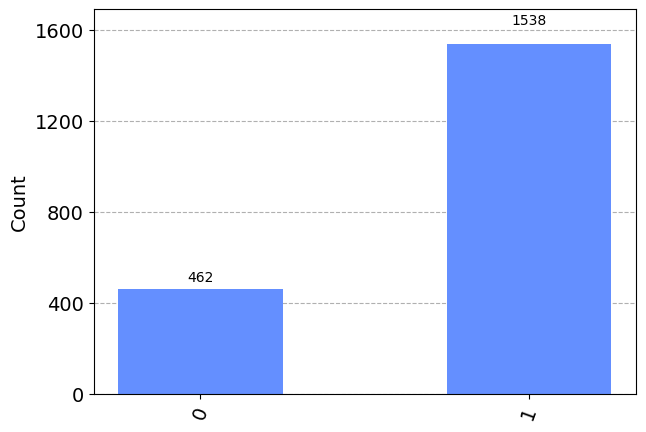

In [63]:
plot_histogram(counts_r[index])

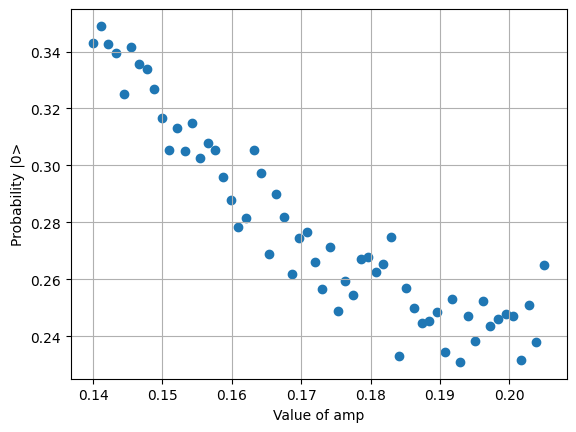

In [65]:
plt.scatter(amps, prob_0)
plt.ylabel('Probability |0>')
plt.xlabel('Value of amp')
plt.grid()

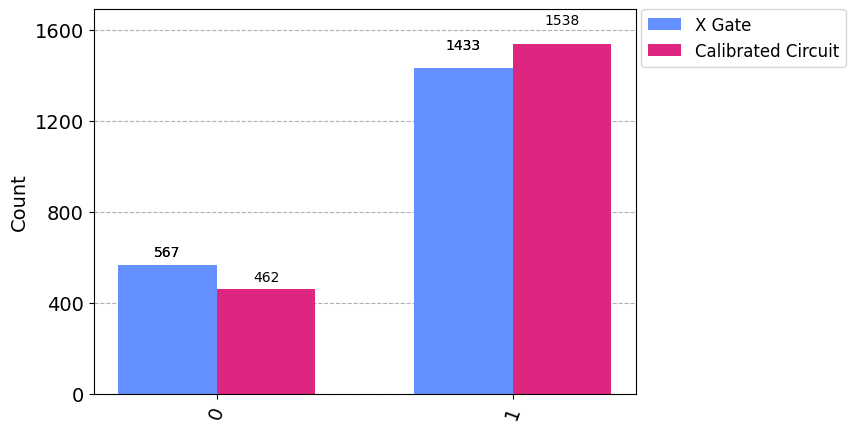

In [123]:
plot_histogram([counts_Xgate, counts_r[index]], legend = ['X Gate', 'Calibrated Circuit'])

In [74]:
print(1433/2000, 567/2000, 462/2000, 1538/2000)

0.7165 0.2835 0.231 0.769


As we can clearly see the values are much better now, the optimal value made the X-gate better, even though it wasn't a lot it still improved and we can see the pattern for the relationship between the amplitude and the probability. What we can clearly state here is the necessity of error-correcting code, afterall even when running a simple circuit as this one we still face a lot of noise, with only 71,65% of the shots getting a circuit in the state |1>. Nonetheless it still shows that the Pulse Model can improve when in comparison with the Circuit Model. 

To do Next: Synthesize results in one notebook and in one latex pdf. 
To the CNOT optimization
Think of a machine learning algorithm to maybe find what the best value is. 